In [1]:
import bempp.api
import numpy as np
import time
from login import gmres 
from operators import PMCHWT_operator

# bempp.api.enable_console_logging()
bempp.api.set_ipython_notebook_viewer()

In [2]:
from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

quad_mu= [1,1,1,1]
quad_nu= [4,3,2,6]
# quad_dense = [4,4,4,6]

mu = 0.1
nu = 0.001

In [3]:
################################################
# Parameters nu

parameters_nu = global_parameters()
if nu == -1:
	parameters_nu.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_nu.assembly.boundary_operator_assembly_type='hmat'
parameters_nu.hmat.eps = nu
parameters_nu.quadrature.double_singular = quad_nu[3]
parameters_nu.quadrature.far.double_order = quad_nu[2]
parameters_nu.quadrature.medium.double_order = quad_nu[1]
parameters_nu.quadrature.near.double_order = quad_nu[0]

################################################
################################################
# Parameters mu near field

parameters_mu_nf = global_parameters()
if mu == -1:
	parameters_mu_nf.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_mu_nf.assembly.boundary_operator_assembly_type='hmat'
parameters_mu_nf.hmat.eps = mu
parameters_mu_nf.quadrature.double_singular = quad_mu[3]
parameters_mu_nf.quadrature.far.double_order = quad_mu[2]
parameters_mu_nf.quadrature.medium.double_order = quad_mu[1]
parameters_mu_nf.quadrature.near.double_order = quad_mu[0]
parameters_mu_nf.hmat.cutoff = 0


In [4]:
def rescale(A, d1, d2):
    """Rescale the 2x2 block operator matrix A"""
    
    A[0, 1] = A[0, 1] * (d2 / d1)
    A[1, 0] = A[1, 0] * (d1 / d2)
    
    return A

In [5]:
def get_memory(number_of_scatterers, operator):
    mem = 0
    
    if number_of_scatterers == 1:
        for i in range(2*number_of_scatterers):
            for j in range(2*number_of_scatterers):
                mem += operator[i][j].memory
    else:
        for i in range(2*number_of_scatterers):
            for j in range(2*number_of_scatterers):
                op = operator[i][j]
                mem += op.memory
    return mem

In [6]:
frequency = 183E9
wavelength = (3E8/frequency)*10**3 #scale to mm
print('wavelength: {0}'.format(wavelength))
k_ext = 2 *np.pi/wavelength
print('k_ext: {0}'.format(k_ext))
print('mesh size: {0}'.format(2*np.pi/(10*k_ext)))

if frequency == 50E9:
    r = 1.7754+0.00066j
elif frequency == 183E9:
    r = 1.7754+0.00243j
elif frequency == 325E9:
    r = 1.7754+0.0044j
elif frequency == 664E9:
    r=1.7754+0.00972j

# r = 1.7728+0.00059j 
# r = 1.7728 + 0.015

wavelength: 1.639344262295082
k_ext: 3.8327430373795477
mesh size: 0.16393442622950818


In [7]:
number_of_scatterers = 8
ref_index = [r] * number_of_scatterers
k_int= [k_ext * i for i in ref_index]
# number_of_scatterers = len(k_int)

print("The exterior wavenumber is: {0}".format(k_ext))
print("The interior wavenumbers are: {0}".format(k_int))

mu_int = number_of_scatterers * [1.0]
mu_ext = 1.0

The exterior wavenumber is: 3.8327430373795477
The interior wavenumbers are: [(6.804651988563649+0.0093135655808323j), (6.804651988563649+0.0093135655808323j), (6.804651988563649+0.0093135655808323j), (6.804651988563649+0.0093135655808323j), (6.804651988563649+0.0093135655808323j), (6.804651988563649+0.0093135655808323j), (6.804651988563649+0.0093135655808323j), (6.804651988563649+0.0093135655808323j)]


In [9]:
grids = []
for i in range(number_of_scatterers):
    new_grid = bempp.api.import_grid('8aggregate_183GHz/1cm/hex' + str(i) + '.msh')
    grids.append(new_grid)

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

for i in range(number_of_scatterers):
    vertices = grids[i].leaf_view.vertices
    ax.scatter(vertices[0], vertices[1], vertices[2])

FileNotFoundError: [Errno 2] No such file or directory: '8aggregate_183GHz/1cm/hex0.msh'

In [10]:
sum_elements = 0

for i in range(number_of_scatterers):
    el = grids[0].leaf_view.elements
    sum_elements += el.shape[1]
print(sum_elements)

IndexError: list index out of range

In [10]:
theta = np.pi / 4 # Incident wave travelling at a 60 degree angle
direction = np.array([np.cos(theta), 0, np.sin(theta)])
polarization = np.array([0, 1.0, 0])

def plane_wave(point):
    return polarization * np.exp(1j * k_ext * np.dot(point, direction))

def dirichlet_trace_fun(point, n, domain_index, result):
    result[:] =  np.cross(plane_wave(point), n)

def plane_wave_curl(point):
    return np.cross(direction, polarization) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, direction))

def neumann_trace_fun(point, n, domain_index, result):
    result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl(point), n)

In [12]:
# # spaces
bc_space = [bempp.api.function_space(grid, "BC", 0) for grid in grids]
rbc_space = [bempp.api.function_space(grid, "RBC", 0) for grid in grids]
rwg_space = [bempp.api.function_space(grid, "RWG", 0) for grid in grids]
snc_space = [bempp.api.function_space(grid, "SNC", 0) for grid in grids]

b_rwg_space = [bempp.api.function_space(grid, "B-RWG", 0) for grid in grids]
b_snc_space = [bempp.api.function_space(grid, "B-SNC", 0) for grid in grids]

N = sum([space.global_dof_count for space in rwg_space])
print (N ,'NDOF')

0 NDOF


In [12]:
# set up operators

[PMCHWT_nu, filter_operators_nu] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_nu)
# [_, PMCHWT_diag_nu] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner = True, parameters = parameters_nu)
# [_, PMCHWT_interior_nu] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner=True, parameters = parameters_nu,
#                                           type_of_preconditioner='interior')
[_, PMCHWT_interior_electric_nu] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner=True, parameters=parameters_nu,
                                                   type_of_preconditioner = 'interior_electric')
# [_,PMCHWT_diag_mu_nf]= PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner = True, parameters = parameters_mu_nf)
# [_,PMCHWT_interior_mu_nf] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner = True, 
#                                             parameters = parameters_mu_nf, type_of_preconditioner='interior')
# [_,PMCHWT_interior_electric_mu_nf] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner = True, 
#                                                      parameters = parameters_mu_nf, type_of_preconditioner='interior_electric')
print('Done')

Done


In [11]:
print('creating mass-matrices')
# BC discretisation
mass_matrix_BC_SNC = np.empty((2 * number_of_scatterers, 2 * number_of_scatterers), dtype='O')
t0 = time.time()
for i in range(number_of_scatterers):
    for j in range(number_of_scatterers):
        if i==j:
            id_BC_SNC = bempp.api.operators.boundary.sparse.identity(bc_space[i], bc_space[i], b_snc_space[i])
            inv_identity_BC_SNC = bempp.api.assembly.InverseSparseDiscreteBoundaryOperator(id_BC_SNC.weak_form())
            mass_matrix_BC_SNC[2*i, 2*j] = inv_identity_BC_SNC
            mass_matrix_BC_SNC[2*i + 1, 2*j + 1] = inv_identity_BC_SNC
mass_matrix_BC_SNC = bempp.api.assembly.BlockedDiscreteOperator(mass_matrix_BC_SNC)
ta_mass_matrix_BC_SNC = time.time() - t0
print('assembly time for mass_matrix_BC_SNC: {0}'.format(ta_mass_matrix_BC_SNC))

mass_matrix_BRWG_RBC = np.empty((2*number_of_scatterers, 2*number_of_scatterers), dtype = 'O')
t0 = time.time()
for i in range(number_of_scatterers):
    for j in range(number_of_scatterers):
        if i==j:
            id_BRWG_RBC = bempp.api.operators.boundary.sparse.identity(b_rwg_space[i], b_rwg_space[i], rbc_space[i])
            inv_identity_BRWG_RBC = bempp.api.assembly.InverseSparseDiscreteBoundaryOperator(id_BRWG_RBC.weak_form())
            mass_matrix_BRWG_RBC[2*i, 2*j] = inv_identity_BRWG_RBC
            mass_matrix_BRWG_RBC[2*i + 1, 2*j+1] = inv_identity_BRWG_RBC
mass_matrix_BRWG_RBC = bempp.api.assembly.BlockedDiscreteOperator(mass_matrix_BRWG_RBC)
ta_mass_matrix_BRWG_RBC = time.time() - t0
print('assembly time for mass_matrix_bc: {0}'.format(ta_mass_matrix_BRWG_RBC))

creating mass-matrices


NameError: name 'bc_space' is not defined

In [14]:
print('assembly of PMCHWT operator - rwg discretisation - parameters_nu')

t0 = time.time()
PMCHWT_nu_wf = PMCHWT_nu.weak_form()
PMCHWT_nu_sf = mass_matrix_BC_SNC * PMCHWT_nu_wf
ta_PMCHWT_nu_sf = time.time() - t0 + ta_mass_matrix_BC_SNC
print('assembly time of op_nu_wf: {0}'.format(ta_PMCHWT_nu_sf))

assembly of PMCHWT operator - rwg discretisation - parameters_nu
assembly time of op_nu_wf: 123.56513023376465


In [ ]:
print('assembly of Cald nu parameters')
t0 = time.time()
PMCHWT_diag_nu_wf = PMCHWT_diag_nu.weak_form()
op_cald_nu_sf = mass_matrix_BRWG_RBC * PMCHWT_diag_nu_wf * PMCHWT_nu_sf
ta_cald_nu_sf = time.time() - t0 + ta_PMCHWT_nu_sf +ta_mass_matrix_BRWG_RBC
print('assembly time sf: {0}'.format(ta_cald_nu_sf))

In [ ]:
print('assembly of interior nu parameters')
t0 = time.time()
PMCHWT_interior_nu_wf = PMCHWT_interior_nu.weak_form()
op_interior_nu_sf = mass_matrix_BRWG_RBC * PMCHWT_interior_nu_wf * PMCHWT_nu_sf
ta_interior_nu_sf = time.time() - t0 + ta_PMCHWT_nu_sf + ta_mass_matrix_BRWG_RBC
print('assembly time sf: {0}'.format(ta_interior_nu_sf))

In [15]:
print('assembly of interior-electric nu parameters')
t0 = time.time()
PMCHWT_interior_electric_nu_wf = PMCHWT_interior_electric_nu.weak_form()
op_interior_electric_nu_sf = mass_matrix_BRWG_RBC * PMCHWT_interior_electric_nu_wf * PMCHWT_nu_sf
ta_interior_electric_nu_sf = time.time() - t0 + ta_PMCHWT_nu_sf + ta_mass_matrix_BRWG_RBC
print('assembly time sf: {0}'.format(ta_interior_electric_nu_sf))

assembly of interior-electric nu parameters
assembly time sf: 243.91487407684326


In [ ]:
print('assembly of bi-Cald prec near field')
t0 = time.time()
PMCHWT_diag_mu_nf_wf = PMCHWT_diag_mu_nf.weak_form()
op_cald_bi_nf_sf = mass_matrix_BRWG_RBC * PMCHWT_diag_mu_nf_wf * PMCHWT_nu_sf
ta_cald_bi_nf_sf = time.time() - t0 + ta_PMCHWT_nu_sf + ta_mass_matrix_BRWG_RBC 
print('time_sf: {0}'.format(ta_cald_bi_nf_sf))

In [16]:
print('assembly of interior prec near field')
t0 = time.time()
PMCHWT_interior_mu_nf_wf = PMCHWT_interior_mu_nf.weak_form()
op_interior_bi_nf_sf = mass_matrix_BRWG_RBC * PMCHWT_interior_mu_nf_wf * PMCHWT_nu_sf
ta_interior_bi_nf_sf = time.time() - t0 + ta_PMCHWT_nu_sf + ta_mass_matrix_BRWG_RBC 
print('time_sf: {0}'.format(ta_interior_bi_nf_sf))

assembly of interior prec near field
time_sf: 2953.759608268738


In [16]:
print('assembly of interior-electric prec near field')
t0 = time.time()
PMCHWT_interior_electric_mu_nf_wf = PMCHWT_interior_electric_mu_nf.weak_form()
op_interior_electric_bi_nf_sf = mass_matrix_BRWG_RBC * PMCHWT_interior_electric_mu_nf_wf * PMCHWT_nu_sf
ta_interior_electric_bi_nf_sf = time.time() - t0 + ta_PMCHWT_nu_sf + ta_mass_matrix_BRWG_RBC 
print('time_sf: {0}'.format(ta_interior_electric_bi_nf_sf))

assembly of interior-electric prec near field
time_sf: 2557.6234345436096


In [ ]:
# print('assembly of block PMCHWT')
# t0 = time.time()
# PMCHWT_block_sf = PMCHWT_block.strong_form()
# ta_PMCHWT_block_sf = time.time() -t0

# t0 = time.time()
# PMCHWT_block_diag_sf = PMCHWT_block_diag.strong_form()
# ta_PMCHWT_block_diag_sf = time.time() - t0


# ############
# t0 = time.time()
# op_cald_block_sf = PMCHWT_block_diag_sf * PMCHWT_block_sf
# ta_op_cald_block_sf = time.time() - t0 + ta_PMCHWT_block_sf + ta_PMCHWT_block_diag_sf

# print('time cald_block_sf: {0}'.format(ta_op_cald_block_sf))

In [ ]:
# Assembly of RHS operators
## Discretize the incident field
print('defining incident field - RWG')
incident_field_RWG = number_of_scatterers * [None]
for i in range(number_of_scatterers):
    dirichlet_trace_RWG = bempp.api.GridFunction(rwg_space[i], fun=dirichlet_trace_fun)
    neumann_trace_RWG = (k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun = neumann_trace_fun)
    incident_field_RWG[i] = dirichlet_trace_RWG.coefficients.tolist() +  neumann_trace_RWG.coefficients.tolist()

print('rhs_nu wf')
rhs_nu_wf = []#number_of_scatterers * [None]
for i in range(number_of_scatterers):
    rhs_nu_wf.append(filter_operators_nu[i].weak_form() * incident_field_RWG[i])
rhs_nu_wf = [y for x in rhs_nu_wf for y in x]

# print('rhs_cald_nu sf')
# rhs_cald_nu_sf = mass_matrix_BRWG_RBC * PMCHWT_diag_nu_wf * mass_matrix_BC_SNC * rhs_nu_wf

# print('rhs_interior_nu_sf')
# rhs_interior_nu_sf = mass_matrix_BRWG_RBC * PMCHWT_interior_nu_wf * mass_matrix_BC_SNC * rhs_nu_wf

print('rhs_interior_electric_nu_sf')
rhs_interior_electric_nu_sf = mass_matrix_BRWG_RBC * PMCHWT_interior_electric_nu_wf * mass_matrix_BC_SNC * rhs_nu_wf

# print('rhs_cald_bi_nf_sf')
# rhs_cald_bi_nf_sf = mass_matrix_BRWG_RBC * PMCHWT_diag_mu_nf_wf * mass_matrix_BC_SNC * rhs_nu_wf

# print('rhs_interior_bi_nf_sf')
# rhs_interior_bi_nf_sf = mass_matrix_BRWG_RBC * PMCHWT_interior_mu_nf_wf * mass_matrix_BC_SNC * rhs_nu_wf

# print('rhs_interior_electric_bi_nf_sf')
# rhs_interior_electric_bi_nf_sf = mass_matrix_BRWG_RBC * PMCHWT_interior_electric_mu_nf_wf * mass_matrix_BC_SNC * rhs_nu_wf

defining incident field - RWG
rhs_nu wf
rhs_interior_electric_nu_sf


In [ ]:
# print('defining incident field - block')
# incident_field_block = 2 * number_of_scatterers * [None]
# for i in range(number_of_scatterers):
#     dirichlet_trace_block = bempp.api.GridFunction(PMCHWT_block.domain_spaces[2*i], dual_space=PMCHWT_block.dual_to_range_spaces[2*i], fun=dirichlet_trace_fun)
#     neumann_trace_block = (k_ext/mu_ext) * bempp.api.GridFunction(PMCHWT_block.domain_spaces[2*i+1], dual_space=PMCHWT_block.dual_to_range_spaces[2*i+1], fun=neumann_trace_fun)
#     incident_field_block[i] = dirichlet_trace_block.coefficients.tolist() + neumann_trace_block.coefficients.tolist()

# print('rhs_block wf & sf')
# rhs_block_sf = []
# for i in range(number_of_scatterers):
#     rhs_block_sf.append(filter_operators_block[i].strong_form() * incident_field_block[i])
# rhs_block_sf = [y for x in rhs_block_sf for y in x]

# print('rhs_cald_block wf & sf')
# rhs_cald_block_sf = PMCHWT_block_diag_sf * rhs_block_sf

In [25]:
#### solving the linear system
tolerance = 1e-5
restart = 200
maxiter = 5000


# print('solving Calderon nu parameters')
# t0 = time.time()
# c_cald_nu_sf, info_cald_nu_sf, res_cald_nu_sf = gmres(op_cald_nu_sf, rhs_cald_nu_sf, tol = tolerance, restart=restart,
#                                                      return_residuals=True, maxiter=maxiter)
# ts_cald_nu_sf = time.time() - t0
# print('number of iterations: {0} \n time: {1}'.format(len(res_cald_nu_sf), ts_cald_nu_sf))

# print('solving interior nu parameters')
# t0 = time.time()
# c_interior_nu_sf, info_interior_nu_sf, res_interior_nu_sf = gmres(op_interior_nu_sf, rhs_interior_nu_sf, tol = tolerance, 
#                                                                   restart=restart,
#                                                                   return_residuals=True, maxiter=maxiter)
# ts_interior_nu_sf = time.time() - t0
# print('number of iterations: {0} \n time: {1}'.format(len(res_interior_nu_sf), ts_interior_nu_sf))

print('solving interior-electric nu parameters')
t0 = time.time()
c_interior_electric_nu_sf, info_interior_electric_nu_sf, res_interior_electric_nu_sf = gmres(op_interior_electric_nu_sf, 
                                                                                             rhs_interior_electric_nu_sf,
                                                                                             tol = tolerance, restart=restart,
                                                                                             return_residuals=True, 
                                                                                             maxiter=maxiter)
ts_interior_electric_nu_sf = time.time() - t0
print('number of iterations: {0} \n time: {1}'.format(len(res_interior_electric_nu_sf), ts_interior_electric_nu_sf))

# print('solver of bi-Calderon near field sf')
# t0 = time.time()
# c_cald_bi_nf_sf,  info_cald_bi_nf_sf, res_cald_bi_nf_sf  = gmres(op_cald_bi_nf_sf, rhs_cald_bi_nf_sf, tol=tolerance, restart=restart, 
#                                                                 return_residuals=True, maxiter=maxiter)
# ts_cald_bi_nf_sf = time.time()-t0
# print('number of iterations: {0} \n time: {1}'.format(len(res_cald_bi_nf_sf), ts_cald_bi_nf_sf))

# print('solver of bi-interior near field sf')
# t0 = time.time()
# c_interior_bi_nf_sf,  info_interior_bi_nf_sf, res_interior_bi_nf_sf  = gmres(op_interior_bi_nf_sf, rhs_interior_bi_nf_sf, 
#                                                                              tol=tolerance, restart=restart, 
#                                                                              return_residuals=True, maxiter=maxiter)
# ts_interior_bi_nf_sf = time.time()-t0
# print('number of iterations: {0} \n time: {1}'.format(len(res_interior_bi_nf_sf), ts_interior_bi_nf_sf))

# print('solver of bi-interior-electric near field sf')
# t0 = time.time()
# c_interior_electric_bi_nf_sf,  info_interior_electric_bi_nf_sf, res_interior_electric_bi_nf_sf  = gmres(op_interior_electric_bi_nf_sf, 
#                                                                                                         rhs_interior_electric_bi_nf_sf, 
#                                                                                                         tol=tolerance, restart=restart, 
#                                                                                                         return_residuals=True, maxiter=maxiter)
# ts_interior_electric_bi_nf_sf = time.time()-t0
# print('number of iterations: {0} \n time: {1}'.format(len(res_interior_electric_bi_nf_sf), ts_interior_electric_bi_nf_sf))


solving interior-electric nu parameters
number of iterations: 3198 
 time: 5868.213444709778


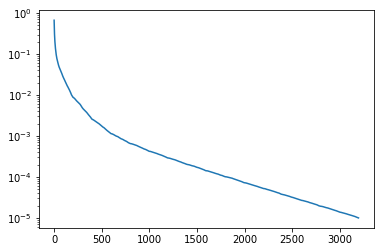

In [26]:
plt.semilogy(res_interior_electric_nu_sf)

In [27]:
res_interior_electric_nu_sf[-1]

9.9788953962613301e-06

In [ ]:
# mem_pre_nu_wf = get_memory(number_of_scatterers, PMCHWT_diag_nu_wf)
# mem_interior_nu_wf = get_memory(number_of_scatterers, PMCHWT_interior_nu_wf)
mem_interior_electric_nu_wf = get_memory(number_of_scatterers, PMCHWT_interior_electric_nu_wf)
# mem_pre_bi_wf = get_memory(number_of_scatterers, PMCHWT_diag_mu_nf_wf)
# mem_interior_bi_wf = get_memory(number_of_scatterers, PMCHWT_interior_mu_nf_wf)
# mem_interior_electric_bi_wf = get_memory(number_of_scatterers, PMCHWT_interior_electric_mu_nf_wf)

In [28]:
# print('ta_cald_nu_sf = {0}'.format(ta_cald_nu_sf))
# print('ts_cald_nu_sf = {0}'.format(ts_cald_nu_sf))
# print('mem_pre_nu_wf = {0}'.format(mem_pre_nu_wf))
# print('iters_cald_nu_sf = {0}'.format(len(res_cald_nu_sf)))

# print('ta_interior_nu_sf = {0}'.format(ta_interior_nu_sf))
# print('ts_interior_nu_sf = {0}'.format(ts_interior_nu_sf))
# print('mem_interior_nu_wf = {0}'.format(mem_interior_nu_wf))
# print('iters_interior_nu_sf = {0}'.format(len(res_interior_nu_sf)))

print('ta_interior_electric_nu_sf = {0}'.format(ta_interior_electric_nu_sf))
print('ts_interior_electric_nu_sf = {0}'.format(ts_interior_electric_nu_sf))
print('mem_interior_electric_nu_wf = {0}'.format(mem_interior_electric_nu_wf))
print('iters_interior_electric_nu_sf = {0}'.format(len(res_interior_electric_nu_sf)))

# print('ta_cald_bi_nf_sf = {0}'.format(ta_cald_bi_nf_sf))
# print('ts_cald_bi_nf_sf = {0}'.format(ts_cald_bi_nf_sf))
# print('mem_pre_bi_wf = {0}'.format(mem_pre_bi_wf))
# print('iters_cald_bi_nf_sf = {0}'.format(len(res_cald_bi_nf_sf)))

# print('ta_interior_bi_nf_sf = {0}'.format(ta_interior_bi_nf_sf))
# print('ts_interior_bi_nf_sf = {0}'.format(ts_interior_bi_nf_sf))
# print('mem_interior_bi_wf = {0}'.format(mem_interior_bi_wf))
# print('iters_interior_bi_nf_sf = {0}'.format(len(res_interior_bi_nf_sf)))

# print('ta_interior_electric_bi_nf_sf = {0}'.format(ta_interior_electric_bi_nf_sf))
# print('ts_interior_electric_bi_nf_sf = {0}'.format(ts_interior_electric_bi_nf_sf))
# print('mem_interior_electric_bi_wf = {0}'.format(mem_interior_electric_bi_wf))
# print('iters_interior_electric_bi_nf_sf = {0}'.format(len(res_interior_electric_bi_nf_sf)))


ta_interior_electric_nu_sf = 243.91487407684326
ts_interior_electric_nu_sf = 5868.213444709778
mem_interior_electric_nu_wf = 15348663.921875
iters_interior_electric_nu_sf = 3198


In [18]:
ta_PMCHWT_nu_sf

2096.079815864563

In [17]:
get_memory(number_of_scatterers, PMCHWT_nu_wf)

218224784.0

# Results for 50GHz

In [1]:
ta_PMCHWT_nu_sf = 9.30314326286316
mem_PMCHWT_nu_wf = 279798.0

ta_cald_nu_sf = 38.69108176231384
ts_cald_nu_sf = 6.133894205093384
mem_pre_nu_wf = 2484453.625
iters_cald_nu_sf = 16

ta_interior_nu_sf = 24.27958607673645
ts_interior_nu_sf = 6.592127561569214
mem_interior_nu_wf = 1251092.8125
iters_interior_nu_sf = 28

ta_interior_electric_nu_sf = 17.266040325164795
ts_interior_electric_nu_sf = 15.44853138923645
mem_interior_electric_nu_wf = 642616.40625
iters_interior_electric_nu_sf = 89

ta_cald_bi_nf_sf = 14.72873592376709
ts_cald_bi_nf_sf = 31.291067838668823
mem_pre_bi_wf = 609529.625
iters_cald_bi_nf_sf = 95

ta_interior_bi_nf_sf = 12.179664373397827
ts_interior_bi_nf_sf = 10.738465547561646
mem_interior_bi_wf = 304764.8125
iters_interior_bi_nf_sf = 50

ta_interior_electric_bi_nf_sf = 10.689980030059814
ts_interior_electric_bi_nf_sf = 10.610501527786255
mem_interior_electric_bi_wf = 152382.40625
iters_interior_electric_bi_nf_sf = 66

In [ ]:
mem_pre_nu_wf/mem_PMCHWT_nu_wf

In [23]:
i=0
ef = bempp.api.operators.boundary.maxwell.electric_field(rwg_space[i], rwg_space[i], snc_space[i], k_ext)
ef_bc = bempp.api.operators.boundary.maxwell.electric_field(bc_space[i], bc_space[i], rbc_space[i], k_ext, use_projection_spaces=False)




In [15]:
ef_wf = ef.weak_form()

09:54:20:Host dps32:Rank 0:root:INFO: EFIE. START ASSEMBLY. Dim: (378, 378). Assembly Type hmat
09:54:20:Host dps32:Rank 0:root:INFO: EFIE. FINISHED ASSEMBLY. Time: 2.20E-01 sec. Mem Size (Mb) 2.32E+00. Compression: 1.07E+00.


In [24]:
ef_bc_wf = ef_bc.weak_form()

09:57:22:Host dps32:Rank 0:root:INFO: EFIE. START ASSEMBLY. Dim: (378, 378). Assembly Type hmat
09:58:13:Host dps32:Rank 0:root:INFO: EFIE. FINISHED ASSEMBLY. Time: 5.07E+01 sec. Mem Size (Mb) 2.16E+00. Compression: 9.91E-01.


In [25]:
print(ef_wf.memory)

2379.0


In [26]:
print(ef_bc_wf.memory)

2213.0


In [27]:
print(ef_bc_wf.memory/ef_wf.memory)

0.930222782681799


# Results for 183GHz

In [1]:
ta_PMCHWT_nu_sf = 123.4242696762085
mem_PMCHWT_nu_wf = 9273650.0

ta_cald_nu_sf = 549.7623393535614
ts_cald_nu_sf = 322.091721534729
mem_pre_nu_wf = 53844795.6875
iters_cald_nu_sf = 77

ta_interior_nu_sf = 346.42875480651855
ts_interior_nu_sf = 378.4247658252716
mem_interior_nu_wf = 28212177.84375
iters_interior_nu_sf = 148

# ta_interior_electric_nu_sf = 252.7942190170288
# ts_interior_electric_nu_sf = 687.7158274650574
# mem_interior_electric_nu_wf = 15348663.921875
# iters_interior_electric_nu_sf = 400

#also tried S^i with maxiter = 5000 
# ta_interior_electric_nu_sf = 243.91487407684326
# ts_interior_electric_nu_sf = 5868.213444709778
# mem_interior_electric_nu_wf = 15348663.921875
# iters_interior_electric_nu_sf = 3198
#

ta_cald_bi_nf_sf = 200.34766960144043
ts_cald_bi_nf_sf = 494.42973041534424
mem_pre_bi_wf = 5801767.6875
iters_cald_bi_nf_sf = 158

ta_interior_bi_nf_sf = 161.2762999534607
ts_interior_bi_nf_sf = 240.08003091812134
mem_interior_bi_wf = 2900883.84375
iters_interior_bi_nf_sf = 122

ta_interior_electric_bi_nf_sf = 144.10506534576416
ts_interior_electric_bi_nf_sf = 171.6575903892517
mem_interior_electric_bi_wf = 1450441.921875
iters_interior_electric_bi_nf_sf = 124

# Results for 325GHz

In [1]:
# results for 325GHz
ta_PMCHWT_nu_sf = 402.6476113796234
mem_PMCHWT_nu_wf = 39269074.0

ta_cald_nu_sf = 2010.1152694225311
ts_cald_nu_sf = 3150.4270570278168
mem_pre_nu_wf = 212827485.0625
iters_cald_nu_sf = 181

ta_interior_nu_sf = 1203.1498942375183
ts_interior_nu_sf = 3731.326992034912
mem_interior_nu_wf = 113038420.53125
iters_interior_nu_sf = 368

# ta_interior_electric_nu_sf = 829.8578546047211
# ts_interior_electric_nu_sf = 5238.98911523819
# mem_interior_electric_nu_wf = 63382028.265625
# iters_interior_electric_nu_sf = 800 #reached maximum number of iterations

# also tried S^i with maxiter = 2000
ta_interior_electric_nu_sf = 855.5089135169983
ts_interior_electric_nu_sf = 9592.018919706345
mem_interior_electric_nu_wf = 63382028.265625
iters_interior_electric_nu_sf = 1486


ta_cald_bi_nf_sf = 675.0021326541901
ts_cald_bi_nf_sf = 2071.830919265747
mem_pre_bi_wf = 20063689.0625
iters_cald_bi_nf_sf = 190

ta_interior_bi_nf_sf = 543.0668017864227
ts_interior_bi_nf_sf = 1446.9822089672089
mem_interior_bi_wf = 10031844.53125
iters_interior_bi_nf_sf = 215

ta_interior_electric_bi_nf_sf = 474.5538191795349
ts_interior_electric_bi_nf_sf = 1006.697327375412
mem_interior_electric_bi_wf = 5015922.265625
iters_interior_electric_bi_nf_sf = 214

# Results for 664GHz

In [1]:
ta_PMCHWT_nu_sf = 2096.079815864563
mem_PMCHWT_nu_wf = 218224784.0

ta_interior_bi_nf_sf = 2953.759608268738
ts_interior_bi_nf_sf = 5443.070297718048
mem_interior_bi_wf = 37296451.640625
iters_interior_bi_nf_sf = 167

ta_interior_electric_bi_nf_sf = 2582.698178768158
ts_interior_electric_bi_nf_sf = 3744.66814661026
mem_interior_electric_bi_wf = 18648225.8203125
iters_interior_electric_bi_nf_sf = 166

In [2]:
print(ta_PMCHWT_nu_sf/60)
print(ta_interior_electric_bi_nf_sf/60)
print(ts_interior_electric_bi_nf_sf/60)

34.93466359774272
43.04496964613597
62.41113577683767


In [3]:
print(mem_PMCHWT_nu_wf/mem_interior_electric_bi_wf)

11.702174035360489


In [4]:
18648225/2*10**(-6)

9.3241125

In [5]:
218224784.0/2*10**(-6)

109.112392

# Comparing results

In [3]:
number_of_scatterers = 8
tolerance = 1e-5
restart = 200
maxiter = 2000
import numpy as np

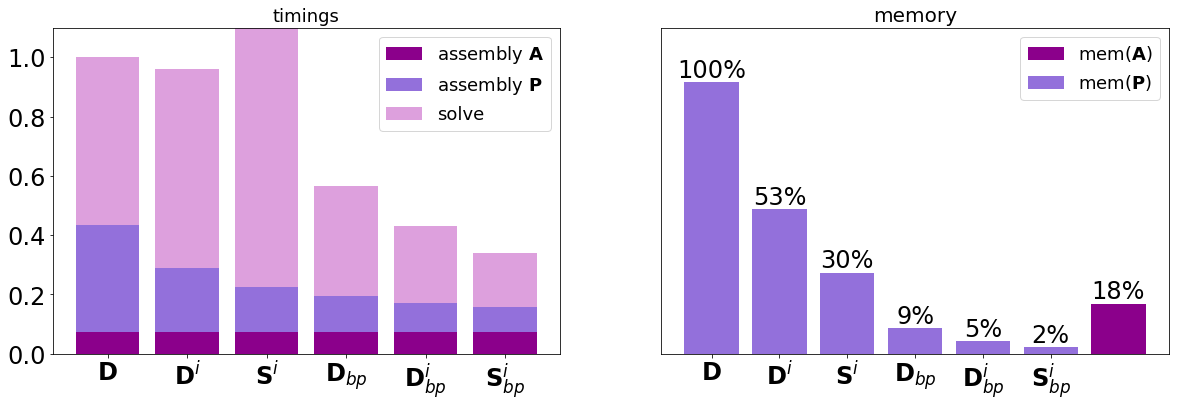

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24})

xtickslist = list([r'$\mathbf{D}$', r'$\mathbf{D}^i$', r'$\mathbf{S}^i$', 
              r'$\mathbf{D}_{bp}$', r'$\mathbf{D}^i_{bp}$', r'$\mathbf{S}^i_{bp}$'])

x = [0,1,2,3,4,5]
xx = [6]
ta_op = [ta_PMCHWT_nu_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf)]*6
ta =  [ta_cald_nu_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf), ta_interior_nu_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf), 
       ta_interior_electric_nu_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf), ta_cald_bi_nf_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf), 
       ta_interior_bi_nf_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf), ta_interior_electric_bi_nf_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf)]
ts = [ts_cald_nu_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf), ts_interior_nu_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf), 
      ts_interior_electric_nu_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf), ts_cald_bi_nf_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf), 
      ts_interior_bi_nf_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf), ts_interior_electric_bi_nf_sf/(ta_cald_nu_sf + ts_cald_nu_sf + ta_PMCHWT_nu_sf)]
mem =  [mem_pre_nu_wf/mem_pre_nu_wf, mem_interior_nu_wf/mem_pre_nu_wf, mem_interior_electric_nu_wf/mem_pre_nu_wf,
        mem_pre_bi_wf/mem_pre_nu_wf, mem_interior_bi_wf/mem_pre_nu_wf, mem_interior_electric_bi_wf/mem_pre_nu_wf]
iterations = [iters_cald_nu_sf, iters_interior_nu_sf, iters_interior_electric_nu_sf, 
              iters_cald_bi_nf_sf, iters_interior_bi_nf_sf, iters_interior_electric_bi_nf_sf]
# matvecs = [4*number_of_scatterers*(number_of_scatterers + 3) * (iters_cald_nu_sf + np.floor(iters_cald_nu_sf/restart)) + 8 * number_of_scatterers,
#            4*number_of_scatterers*(number_of_scatterers + 2) * (iters_interior_nu_sf + np.floor(iters_interior_nu_sf/restart)) + 4 * number_of_scatterers, 
#            2*number_of_scatterers*(2*number_of_scatterers + 3)* (iters_interior_electric_nu_sf + np.floor(iters_interior_electric_nu_sf/restart)) + 2 * number_of_scatterers, 
#            4*number_of_scatterers*(number_of_scatterers + 3) * (iters_cald_bi_nf_sf + np.floor(iters_cald_bi_nf_sf/restart)) + 8 * number_of_scatterers,
#            4*number_of_scatterers*(number_of_scatterers + 2) * (iters_interior_bi_nf_sf + np.floor(iters_interior_bi_nf_sf/restart)) + 4 * number_of_scatterers, 
#            2*number_of_scatterers*(2*number_of_scatterers + 3)* (iters_interior_electric_bi_nf_sf + np.floor(iters_interior_electric_bi_nf_sf/restart)) + 2 * number_of_scatterers   
#            ]

fig, axs = plt.subplots(1,2,figsize = (20,6))
plt.setp(axs, xticks=x, xticklabels=xtickslist)

ta_A_bar = axs[0].bar(x, ta_op, label = r'assembly $\mathbf{A}$', color = 'darkmagenta')
ta_P_bar = axs[0].bar(x, ta, bottom = ta_op, label = r'assembly $\mathbf{P}$', color = 'mediumpurple')
ts_bar = axs[0].bar(x, ts, bottom = np.array(ta) + np.array(ta_op), label = 'solve', color = 'plum')
axs[0].legend(fontsize = 18)
axs[0].set_title('timings', fontsize = 18)
axs[0].set_ylim([0,1.1])

mem_bar2 = axs[1].bar(xx, [mem_PMCHWT_nu_wf/mem_pre_nu_wf], color = 'darkmagenta', label = r'mem($\mathbf{A}$)')
mem_bar = axs[1].bar(x, mem, color = 'mediumpurple', label = r'mem($\mathbf{P}$)')
axs[1].legend(fontsize = 18)
axs[1].set_title('memory', fontsize = 20)
axs[1].set_ylim([0,1.2])
axs[1].set_yticks([])

# axs[2].bar([i-0.2 for i in x],iterations, width = 0.4, label = 'iterations')
# ax2 = axs[2].twinx()
# ax2.bar([i+0.2 for i in x], matvecs, width = 0.4, color = 'orange', label = 'matvecs')
# axs[2].legend(fontsize = 16, loc = 'upper left')
# ax2.legend(fontsize = 16, loc = 'center left')
# axs[2].set_ylabel('Iterations', fontsize = 20)
# ax2.set_ylabel('matvecs', fontsize = 20)

# for i in range(3):
#     for tick in axs[i].get_xticklabels():
#             tick.set_rotation(45)

for rect in mem_bar:
    height = rect.get_height()
    axs[1].text(rect.get_x() + rect.get_width()/2.0, height, "{:.0%}".format(height), ha='center', va='bottom')
    
for rect in mem_bar2:
    height = rect.get_height()
    axs[1].text(rect.get_x() + rect.get_width()/2.0, height, "{:.0%}".format(height), ha='center', va='bottom')

# plt.tight_layout()
# fig.savefig('325GHz.png', format = 'png', dpi = 300)

In [ ]:
plt.semilogy(res_interior_electric_nu_sf)

In [ ]:
table = [ta, ts, mem, [int(i) for i in iterations], [int(i) for i in matvecs]]

In [ ]:
lines = list(['assembly time', 'solve time', 'mem', 'iterations', 'matvecs'])
cols = xtickslist

In [ ]:
import pandas as pd
pd.set_option('display.precision',10)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 15)

result = pd.DataFrame(table,index = lines,columns = cols)


In [ ]:
result

# Extrapolating for 664GHz

In [1]:
M = [2556, 26418, 81318, 332523]
N = [2556, 26418, 81318]

In [2]:
mem_pre_nu_wf = [2484453.625, 53844795.6875, 212827485.0625]
mem_interior_nu_wf = [1251092.8125, 28212177.84375, 113038420.53125]
mem_interior_electric_nu_wf = [642616.40625, 15348663.921875,63382028.265625]
mem_pre_bi_wf = [609529.625, 5801767.6875,20063689.0625]
mem_interior_bi_wf = [304764.8125, 2900883.84375,10031844.53125]
mem_interior_electric_bi_wf = [152382.40625, 1450441.921875,5015922.265625]

In [65]:
iters_cald_nu_sf = [16, 77, 181]
ta_cald_nu_sf = [38.69108176231384, 549.7623393535614, 2010.1152694225311]
ts_cald_nu_sf = [6.133894205093384, 322.091721534729, 3150.4270570278168]

ta_interior_nu_sf = [24.27958607673645, 346.42875480651855, 1203.1498942375183]
ts_interior_nu_sf = [6.592127561569214, 378.4247658252716, 3731.326992034912]

ta_interior_electric_nu_sf = [17.266040325164795, 252.7942190170288, 829.8578546047211]
ts_interior_electric_nu_sf = [15.44853138923645, 687.7158274650574, 5238.98911523819]

ta_cald_bi_nf_sf = [14.72873592376709, 200.34766960144043, 675.0021326541901]
ts_cald_bi_nf_sf = [31.291067838668823, 494.42973041534424, 2071.830919265747]

ta_interior_bi_nf_sf = [12.179664373397827, 161.2762999534607, 543.0668017864227]
ts_interior_bi_nf_sf = [10.738465547561646, 240.08003091812134, 1446.9822089672089]

ta_interior_electric_bi_nf_sf = [10.689980030059814, 144.10506534576416, 474.5538191795349]
ts_interior_electric_bi_nf_sf = [10.610501527786255, 171.6575903892517, 1006.697327375412]

In [67]:
from scipy import optimize
import numpy as np

def test_func(x, A, alpha):
    return np.log(A) + alpha*x + np.log(x)

def gmres_approx(x, A): # x = N * iters **2
    return A * x

def gmres_iters_approx(x, A, alpha):
    return np.log(A) + alpha * x

In [68]:
params_iters_cald_nu, _ = optimize.curve_fit(gmres_iters_approx, np.log(N), np.log(iters_cald_nu_sf))

/home/antigoni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [72]:
y_iters_cald_nu = params_iters_cald_nu[0] * M ** params_iters_cald_nu[1]

In [5]:
params_pre_nu, _ = optimize.curve_fit(test_func, np.log(N), np.log(mem_pre_nu_wf),p0=[1,1])
params_interior_nu, _= optimize.curve_fit(test_func, np.log(N), np.log(mem_interior_nu_wf),p0=[1,1])
params_interior_electric_nu, _ = optimize.curve_fit(test_func, np.log(N), np.log(mem_interior_electric_nu_wf),p0=[1,1])
params_pre_bi, _ = optimize.curve_fit(test_func, np.log(N), np.log(mem_pre_bi_wf),p0=[1,1])
params_interior_bi, _ = optimize.curve_fit(test_func, np.log(N), np.log(mem_interior_bi_wf),p0=[1,1])
params_interior_electric_bi, _ = optimize.curve_fit(test_func, np.log(N), np.log(mem_interior_electric_bi_wf),p0=[1,1])

In [6]:
params_ta_nu, _ = optimize.curve_fit(test_func, np.log(N), np.log(ta_cald_nu_sf),p0=[1,1])
params_ta_interior_nu, _= optimize.curve_fit(test_func, np.log(N), np.log(ta_interior_nu_sf),p0=[1,1])
params_ta_interior_electric_nu, _ = optimize.curve_fit(test_func, np.log(N), np.log(ta_interior_electric_nu_sf),p0=[1,1])
params_ta_bi, _ = optimize.curve_fit(test_func, np.log(N), np.log(ta_cald_bi_nf_sf),p0=[1,1])
params_ta_interior_bi, _ = optimize.curve_fit(test_func, np.log(N), np.log(ta_interior_bi_nf_sf),p0=[1,1])
params_ta_interior_electric_bi, _ = optimize.curve_fit(test_func, np.log(N), np.log(ta_interior_electric_bi_nf_sf),p0=[1,1])

/home/antigoni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


In [53]:
params_ts_nu, _ = optimize.curve_fit(test_func, np.log(N), np.log(ts_cald_nu_sf),p0=[1,1])
params_ts_interior_nu, _= optimize.curve_fit(test_func, np.log(N), np.log(ts_interior_nu_sf),p0=[1,1])
params_ts_interior_electric_nu, _ = optimize.curve_fit(test_func, np.log(N), np.log(ts_interior_electric_nu_sf),p0=[1,1])
params_ts_bi, _ = optimize.curve_fit(test_func, np.log(N), np.log(ts_cald_bi_nf_sf),p0=[1,1])
params_ts_interior_bi, _ = optimize.curve_fit(test_func, np.log(N), np.log(ts_interior_bi_nf_sf),p0=[1,1])
params_ts_interior_electric_bi, _ = optimize.curve_fit(test_func, np.log(N), np.log(ts_interior_electric_bi_nf_sf),p0=[1,1])

/home/antigoni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


In [82]:
# params_ts_nu, _ = optimize.curve_fit(gmres_approx, np.log(N) * (np.array(iters_cald_nu_sf)**2), ts_cald_nu_sf)

/home/antigoni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

In [81]:
# np.log(N) * np.array(iters_cald_nu_sf)**2

array([   2008.62689677,   60367.89738778,  370399.88489815])

In [8]:
y_nu = params_pre_nu[0] * (M**params_pre_nu[1]) * np.log(M)
y_interior_nu = params_interior_nu[0] * (M**params_interior_nu[1]) * np.log(M)
y_interior_electric_nu = params_interior_electric_nu[0] * (M**params_interior_electric_nu[1]) * np.log(M)
y_bi = params_pre_bi[0] * (M**params_pre_bi[1]) * np.log(M)
y_interior_bi = params_interior_bi[0] * (M**params_interior_bi[1]) * np.log(M)
y_interior_electric_bi = params_interior_electric_bi[0] * (M**params_interior_electric_bi[1]) * np.log(M)

In [9]:
y_ta_nu = params_ta_nu[0] * (M**params_ta_nu[1]) * np.log(M)
y_ta_interior_nu = params_ta_interior_nu[0] * (M**params_ta_interior_nu[1]) * np.log(M)
y_ta_interior_electric_nu = params_ta_interior_electric_nu[0] * (M**params_ta_interior_electric_nu[1]) * np.log(M)
y_ta_bi = params_ta_bi[0] * (M**params_ta_bi[1]) * np.log(M)
y_ta_interior_bi = params_ta_interior_bi[0] * (M**params_ta_interior_bi[1]) * np.log(M)
y_ta_interior_electric_bi = params_ta_interior_electric_bi[0] * (M**params_ta_interior_electric_bi[1]) * np.log(M)

In [54]:
y_ts_nu = params_ts_nu[0] * (M**params_ts_nu[1]) * np.log(M)
y_ts_interior_nu = params_ts_interior_nu[0] * (M**params_ts_interior_nu[1]) * np.log(M)
y_ts_interior_electric_nu = params_ts_interior_electric_nu[0] * (M**params_ts_interior_electric_nu[1]) * np.log(M)
y_ts_bi = params_ts_bi[0] * (M**params_ts_bi[1]) * np.log(M)
y_ts_interior_bi = params_ts_interior_bi[0] * (M**params_ts_interior_bi[1]) * np.log(M)
y_ts_interior_electric_bi = params_ts_interior_electric_bi[0] * (M**params_ts_interior_electric_bi[1]) * np.log(M)

In [43]:
# y_ts_nu = params_ts_nu[0] * np.array(M) * 180**2

### Error of extrapolation 

In [57]:
for i in range(3):
    print(np.abs(y_ts_nu[i]-ts_cald_nu_sf[i])/ts_cald_nu_sf[i])

0.0539036450797
0.1859192618
0.108729550397


In [58]:
y_ts_nu/60

array([  9.67209158e-02,   6.36624628e+00,   4.67980423e+01,
         5.61599899e+02])

In [60]:
ts_cald_nu_sf

[6.133894205093384, 322.091721534729, 3150.4270570278168]

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.]),
 <a list of 8 Text yticklabel objects>)

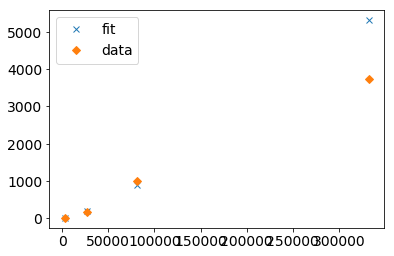

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(M, y_ts_interior_electric_bi, 'x', label = 'fit')
plt.plot(M, ts_interior_electric_bi_nf_sf + [3744.66814661026], 'D', label = 'data')
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

(array([ -500.,     0.,   500.,  1000.,  1500.,  2000.,  2500.,  3000.]),
 <a list of 8 Text yticklabel objects>)

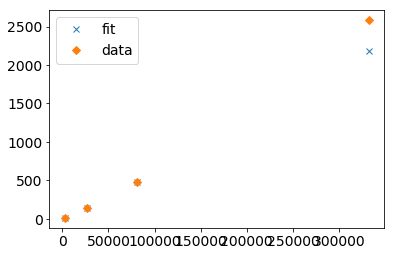

In [13]:
plt.figure()
plt.plot(M, y_ta_interior_electric_bi, 'x', label = 'fit')
plt.plot(M, ta_interior_electric_bi_nf_sf + [2582.698178768158], 'D', label = 'data')
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [14]:
(y_interior_electric_bi[3] - 18648225.8203125)/y_interior_electric_bi[3]

0.01516491286123104

In [15]:
(y_ta_interior_electric_bi[3] - 2582.698178768158)/y_ta_interior_electric_bi[3]

-0.18240500925831249

In [16]:
(y_ts_interior_electric_bi[3] - 3744.66814661026)/y_ts_interior_electric_bi[3]

0.29475720194398458

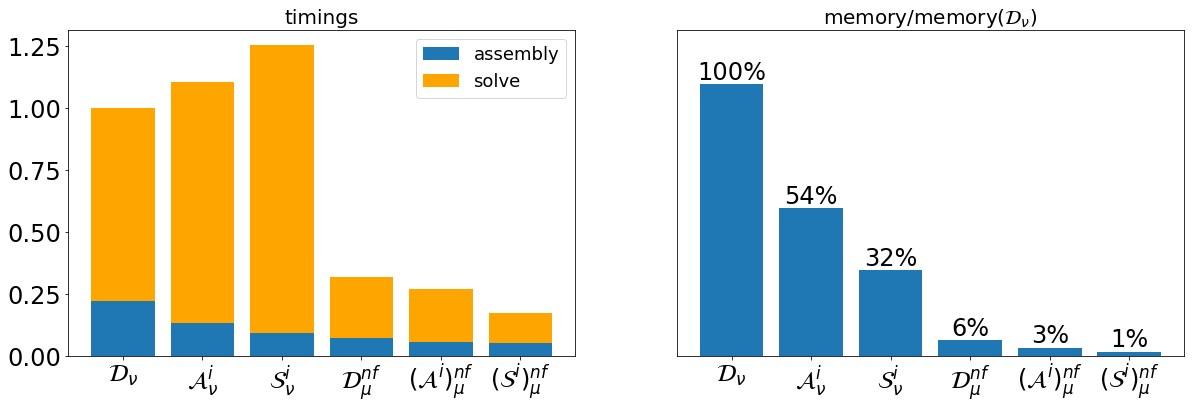

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24})

xtickslist = list([r'$\mathcal{D}_\nu$', r'$\mathcal{A}^i_\nu$', r'$\mathcal{S}^i_\nu$', 
              r'$\mathcal{D}_\mu^{nf}$', r'$(\mathcal{A}^i)_\mu^{nf}$', r'$(\mathcal{S}^i)_\mu^{nf}$'])

x = [0,1,2,3,4,5]
ta =  [y_ta_nu[3]/(y_ta_nu[3] + y_ts_nu[3]), 
       y_ta_interior_nu[3]/(y_ta_nu[3] + y_ts_nu[3]), 
       y_ta_interior_electric_nu[3]/(y_ta_nu[3] + y_ts_nu[3]), 
       y_ta_bi[3]/(y_ta_nu[3] + y_ts_nu[3]), 
       y_ta_interior_bi[3]/(y_ta_nu[3] + y_ts_nu[3]), 
       y_ta_interior_electric_bi[3]/(y_ta_nu[3] + y_ts_nu[3])]
ts = [y_ts_nu[3]/(y_ta_nu[3] + y_ts_nu[3]), 
      y_ts_interior_nu[3]/(y_ta_nu[3] + y_ts_nu[3]), 
      y_ts_interior_electric_nu[3]/(y_ta_nu[3] + y_ts_nu[3]), 
      y_ts_bi[3]/(y_ta_nu[3] + y_ts_nu[3]), 
      y_ts_interior_bi[3]/(y_ta_nu[3] + y_ts_nu[3]), 
      y_ts_interior_electric_bi[3]/(y_ta_nu[3] + y_ts_nu[3])]
mem =  [y_nu[3]/y_nu[3], y_interior_nu[3]/y_nu[3], y_interior_electric_nu[3]/y_nu[3],
        y_bi[3]/y_nu[3], y_interior_bi[3]/y_nu[3], y_interior_electric_bi[3]/y_nu[3]]

fig, axs = plt.subplots(1,2,figsize = (20,6))
plt.setp(axs, xticks=x, xticklabels=xtickslist)

axs[0].bar(x, ta, label = 'assembly')
axs[0].bar(x, ts, bottom = ta, label = 'solve', color = 'orange')
axs[0].legend(fontsize = 18)
axs[0].set_title('timings', fontsize = 20)

mem_bar = axs[1].bar(x, mem)
axs[1].legend(fontsize = 20)
axs[1].set_title(r'memory/memory($\mathcal{D}_\nu$)', fontsize = 20)
axs[1].set_ylim([0,1.2])
axs[1].set_yticks([])



for rect in mem_bar:
    height = rect.get_height()
    axs[1].text(rect.get_x() + rect.get_width()/2.0, height, "{:.0%}".format(height), ha='center', va='bottom')

# plt.tight_layout()

In [23]:
y_ta_interior_electric_bi[3]/(y_ta_nu[3] + y_ts_nu[3]) + y_ts_interior_electric_bi[3]/(y_ta_nu[3] + y_ts_nu[3])

0.17312356848746527

In [22]:
y_ts_interior_electric_bi[3]/(y_ta_nu[3] + y_ts_nu[3])

0.12266348061392629

In [21]:
y_interior_electric_bi[3]/y_nu[3]

0.014552998385411983

In [51]:
y_ta_nu[3]

9591.1958997011479

In [63]:
(np.array(ta_interior_electric_bi_nf_sf) + np.array(ts_interior_electric_bi_nf_sf))/(np.array(ta_cald_nu_sf) + np.array(ts_cald_nu_sf))

array([ 0.47519226,  0.36217375,  0.28703401])

# Plot solution

Saving solution on the boundary for later use

In [ ]:
scattered_field = number_of_scatterers * [None]

counter1 = 0
counter2 = 0
counter3 = 0
for i in range(number_of_scatterers):
    counter1 = counter3
    counter2 = counter3 + rwg_space[i].global_dof_count
    counter3 += 2*rwg_space[i].global_dof_count
    
#     print(counter1, counter2, counter3)
    scattered_field[i] = [c_interior_electric_bi_nf_sf[counter1 : counter2 ], 
                         c_interior_electric_bi_nf_sf[counter2 : counter3]]
    np.savetxt('8aggregate_664GHz/1cm/results/scattered_hex' + str(i) + '_Dirichlet.txt', scattered_field[i][0])
    np.savetxt('8aggregate_664GHz/1cm/results/scattered_hex' + str(i) + '_Neumann.txt', scattered_field[i][1])

In [ ]:
interior_trace_data = number_of_scatterers * [None]

for i in range(number_of_scatterers):
#     print(i)
    interior_trace_data[i] = [incident_field_RWG[i][0:rwg_space[i].global_dof_count] + scattered_field[i][0],
                              (mu_int[i]/k_int[i]) *(incident_field_RWG[i][rwg_space[i].global_dof_count:] + scattered_field[i][1])]
    np.savetxt('8aggregate_664GHz/1cm/results/interior_hex' + str(i) + '_Dirichlet.txt', interior_trace_data[i][0])
    np.savetxt('8aggregate_664GHz/1cm/results/interior_hex' + str(i) + '_Neumann.txt', interior_trace_data[i][1])

loading solution from the boundary

In [ ]:
scattered_field = number_of_scatterers * [None]

for i in range(number_of_scatterers):
    scattered_field[i] = [np.loadtxt('8aggregate_325GHz/1cm/results/scattered_hex' + str(i) + '_Dirichlet.txt', 
                                     dtype=complex, converters={0: lambda s: complex(s.decode().replace('+-', '-'))}),
                          np.loadtxt('8aggregate_325GHz/1cm/results/scattered_hex' + str(i) + '_Neumann.txt', 
                                     dtype=complex, converters={0: lambda s: complex(s.decode().replace('+-', '-'))})
                         ]

In [ ]:
interior_trace_data = number_of_scatterers * [None]

for i in range(number_of_scatterers):
    interior_trace_data[i] = [np.loadtxt('8aggregate_325GHz/1cm/results/interior_hex' + str(i) + '_Dirichlet.txt', 
                                     dtype=complex, converters={0: lambda s: complex(s.decode().replace('+-', '-'))}),
                          np.loadtxt('8aggregate_325GHz/1cm/results/interior_hex' + str(i) + '_Neumann.txt', 
                                     dtype=complex, converters={0: lambda s: complex(s.decode().replace('+-', '-'))})
                         ]

In [ ]:
def normal_vector(v1,v2,v3):
    dir1 = v1 - v2
    dir2 = v3 - v2
    normal = -np.cross(dir1, dir2)
    size = np.linalg.norm(normal)
    return normal/size

In [ ]:
def IsInConvexPoly(normal_of_plane, point_on_plane, point):
    p2f = point_on_plane - point 
    d = np.dot(normal_of_plane, p2f)  
    d = d/np.linalg.norm(d)
    
    if d<-1E-15:
        return 1 # returns 1 if point is outside the polyhedron
    else:
        return 0 # returns 0 if point is inside the polyhedron

In [5]:
# 700 points for 50GHz 1cm
# 500 points for 183GHz 1cm
# 220 points for 325GHz 1cm
# Number of points in the x-direction
nx = 220

# Number of points in the y-direction
nz = 220

# Generate the evaluation points with numpy
shrink_parameter = 4 # original particle at 4cm, divide accordingly to achieve smaller particles
# xmin, xmax, zmin, zmax = [-2, 4.5, -2, 3] # for 1cm particle
# xmin, xmax, zmin, zmax = [-2*4, 4.5*4, -2*4, 3*4] # for 4cm particle

xmin, xmax, zmin, zmax = [-8/shrink_parameter, 18/shrink_parameter, -9/shrink_parameter, 12/shrink_parameter] 
plot_grid = np.mgrid[xmin:xmax:nx * 1j, 0:0:1j, zmin:zmax:nz * 1j]
#define plane of observation
c = 4/shrink_parameter 
#c = -0.1
points = np.vstack((plot_grid[0].ravel(), c * np.ones(plot_grid[0].size),    plot_grid[2].ravel()))


# Compute interior and exterior indices
all_indices = np.ones(points.shape[1], dtype='uint32')
index_sets = number_of_scatterers * [None]

In [ ]:
def convert(s):
    try:
        return float(s)
    except ValueError:
        num, denom = s.split('/')
        return float(num) / float(denom)

In [ ]:
for i in range(number_of_scatterers):
    all_indices_per_scatterer = np.ones(points.shape[1], dtype='uint32')
    print("Scatterer: ", i)
    coords = np.zeros((12,3))
    f = open('8aggregate_50GHz/1cm/hex' + str(i) + '.txt','r') # reading coordinates of polygons making the polyhedron
    x = f.read().splitlines()
    f.close()
    
    j = 0
    for c in x:
        coords[j,:] = c.split(',')[0:3]
        j += 1
#     coords = coords/shrink_parameter
#     if shrink_parameter == 1:
#         if i ==4:
#             coords[:,0] = coords[:,0] #+ 0.7
#             coords[:,2] = coords[:,2] #+ 0.3
    #create the 8 surfaces of the polyhedron
    surface0 = [coords[0], coords[5], coords[4], coords[3], coords[2], coords[1]]
    surface1 = [coords[6], coords[7], coords[4], coords[5]]
    surface2 = [coords[7], coords[8], coords[3], coords[4]]
    surface3 = [coords[8], coords[9], coords[2], coords[3]]
    surface4 = [coords[9], coords[10], coords[1], coords[2]]
    surface5 = [coords[10], coords[11], coords[0], coords[1]]
    surface6 = [coords[11], coords[6], coords[5], coords[0]]
    surface7 = [coords[6], coords[11], coords[10], coords[9], coords[8], coords[7]]
    
    surfaces = [surface0, surface1, surface2, surface3, surface4, surface5, surface6, surface7]
    
    interior_index = np.arange(points.shape[1], dtype='uint32')
    for counter in range(points.shape[1]):
        p = points[:,counter]
        results = []
        for s in surfaces:
            n = normal_vector(s[0], s[1], s[2])
            d = np.dot(n, s[0])
            new_point = (s[0] + s[2])/2
            if IsInConvexPoly(n,new_point, p) == 0: #i.e. if point is inside the polyhedron
                results.append(0)
#                 print("inside")
#         print(len(results))
        if len(results) == 8:
            all_indices_per_scatterer[counter] = 0
      
    
    found_indices = np.arange(points.shape[1], dtype='uint32')[all_indices_per_scatterer == 0]
    all_indices[found_indices] = 0
    index_sets[i] = found_indices
ext_indices = np.arange(points.shape[1], dtype='uint32')[all_indices == 1]
int_indices = np.arange(points.shape[1], dtype='uint32')[all_indices == 0]
# ext_indices = np.arange(points.shape[1], dtype='uint32')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

ext_points = points[:, ext_indices]

plt.scatter(ext_points[0], ext_points[2])

In [ ]:
for i in range(number_of_scatterers):
    int_points = points[:, index_sets[i]]

    plt.figure()
    plt.scatter(int_points[0], int_points[2])

In [ ]:
# bempp.api.global_parameters.quadrature.far.single_order = 6
# bempp.api.global_parameters.quadrature.far.double_order = 4

In [ ]:
bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'
exterior_values = np.zeros((3, len(ext_indices)), dtype='complex128')
interior_values = number_of_scatterers * [None]

for i in range(number_of_scatterers):
    print(i)
    int_points = points[:, index_sets[i]]
    
    if int_points.shape[1] != 0:
        epot_int = bempp.api.operators.potential.maxwell.electric_field(rwg_space[i], int_points, k_int[i])
        mpot_int = bempp.api.operators.potential.maxwell.magnetic_field(rwg_space[i], int_points, k_int[i])
        epot_ext = bempp.api.operators.potential.maxwell.electric_field(rwg_space[i], ext_points, k_ext)
        mpot_ext = bempp.api.operators.potential.maxwell.magnetic_field(rwg_space[i], ext_points, k_ext)

        sc_N = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_field[i][1])
        sc_D = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_field[i][0])

        int_N = bempp.api.GridFunction(rwg_space[i], coefficients = interior_trace_data[i][1])
        int_D = bempp.api.GridFunction(rwg_space[i], coefficients = interior_trace_data[i][0])

        exterior_values += -epot_ext * (mu_ext/k_ext * sc_N) - mpot_ext * sc_D  
        interior_values[i] = (epot_int * int_N + mpot_int * int_D)
    else:
        epot_ext = bempp.api.operators.potential.maxwell.electric_field(rwg_space[i], ext_points, k_ext)
        mpot_ext = bempp.api.operators.potential.maxwell.magnetic_field(rwg_space[i], ext_points, k_ext)

        sc_N = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_field[i][1])
        sc_D = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_field[i][0])
        
        exterior_values += -epot_ext * (mu_ext/k_ext * sc_N) - mpot_ext * sc_D  

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

params = {'legend.fontsize': 22,
         'axes.labelsize': 22,
         'axes.titlesize':22,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)

# First compute the scattered field
scattered_field = np.empty((3, points.shape[1]), dtype='complex128')
scattered_field[:, :] = np.nan
scattered_field[:, ext_indices] = exterior_values

# Now compute the total field
total_field = np.empty((3, points.shape[1]), dtype='complex128')

for i in range(exterior_values.shape[1]):
    total_field[:, ext_indices[i]] = scattered_field[:, ext_indices[i]] + plane_wave(points[:, ext_indices[i]])
    
for i in range(number_of_scatterers):
    # Add interior contributions
    total_field[:, index_sets[i]] = interior_values[i]
    
# Compute the squared field density
squared_scattered_field = np.sum(np.abs(scattered_field)**2, axis=0)
squared_total_field = np.sum(np.abs(total_field)**2, axis=0)

# Show the resulting images
scattered_image = squared_scattered_field.reshape(nx, nz).T
total_image = squared_total_field.reshape(nx, nz).T



In [ ]:
# np.savetxt('8aggregate_325GHz/1cm/results/total_image.txt', total_image)

In [ ]:
# a = np.loadtxt('8aggregate_325GHz/1cm/results/total_image.txt')

In [ ]:
# total_image[total_image > 15] = 10

In [ ]:
fig = plt.figure(figsize =(8, 8))
ax = plt.gca()
ax.set_title("$|E|^2$")

im = plt.imshow(a, origin = 'lower',extent=[xmin, xmax, zmin, zmax] ,clim = (0,6), cmap = 'magma')
# im = plt.imshow(total_image, origin = 'lower',clim = (0,8))


plt.xlabel('$x$')
plt.ylabel('$z$',rotation=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.05)
plt.colorbar(im, cax = cax)